# Question

Is there an easy way to merge circuits, so take 3 pregenerated circuits and merge them to one big one?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymatching
import stim

circ_path = "circuits/"
plot_path = "plots/"

In [2]:
from steane_code_functions import create_surface_steane_ciruit, add_noise
from support_functions import plot_factory_set, count_logical_errors, determine_slope

# Plan to generalize for higher distance codes 

does not work for even number distances! 
    + this is due to an error in my create_stabilizers function, might correct it later 

add basic errors on general qubit data qubits

# Questions 

for general state I should add the second set of stabilizers to the general qubit? 
 -> just a question if I should enable general encoding but there should not be any need for it ...


is this already circuit-level noise? (errors after each gate?)
+ code-capacity model  (just physical dataqubits fail?)
+ phenomenological noise model (stabilizer can fail with fixed prob?)

What should i call this noise model?


# Not yet implemented  (needed?)

idle time errors

layout for arbitrary code size 


In [3]:
# Testing the Construct steane_cirucuit function
test_circ = create_surface_steane_ciruit(
    distance=3,
    fix_X_errors=False,
    detectors=True, 
)

if 1:
    diagram = test_circ.diagram("timeline-svg")  
    with open(circ_path + 'new_test_circ.svg', 'w') as f:
        f.write(str(diagram))
    

In [4]:
def rec_factory(
        distance,
        basic_errors=False,
        fix_X_errors=True,
        fix_Z_errors=True,
        name_str="",
        ):
    def factory_basic(noise, name=False):
        if name:
            if name_str: 
                return name_str
            else:
                return str(distance) 
        else:
            circuit = create_surface_steane_ciruit(
                distance=distance,
                basic_errors=basic_errors,
                noise=noise,
                fix_X_errors=fix_X_errors,
                fix_Z_errors=fix_Z_errors,
            )
            noise_model = {
                    "two_qubit_gate": {
                        "error": "DEPOLARIZE2",
                        "noise": noise,
                    },
                } 
            circuit = add_noise(
                circuit,
                noise_model = noise_model,
                single_qubit_gate_errors=False,
                measurement_errors=False,
                initialize_errors=False, 
            )
            return circuit
    return factory_basic

In [5]:
# Testing the Construct steane_cirucuit function
test_circ = create_surface_steane_ciruit(
    distance=3,
    detectors=True, 
)

if 0:
    diagram = test_circ.diagram("timeline-svg")  
    with open(circ_path + 'test_circ.svg', 'w') as f:
        f.write(str(diagram))
    
    diagram = test_circ.diagram("timeslice-svg")  
    with open(circ_path + 'timeslice.svg', 'w') as f:
        f.write(str(diagram))

count_logical_errors(test_circ,10)


0

<Figure size 640x480 with 0 Axes>

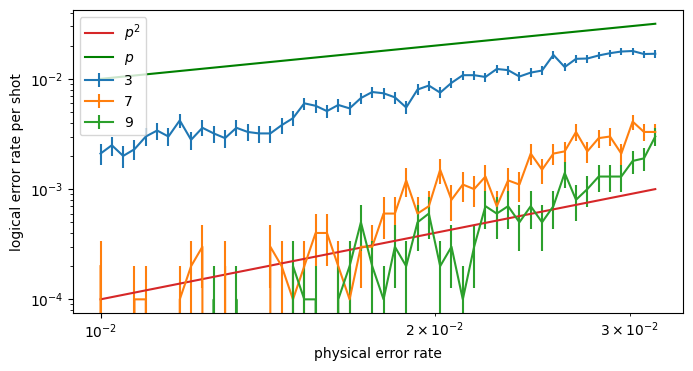

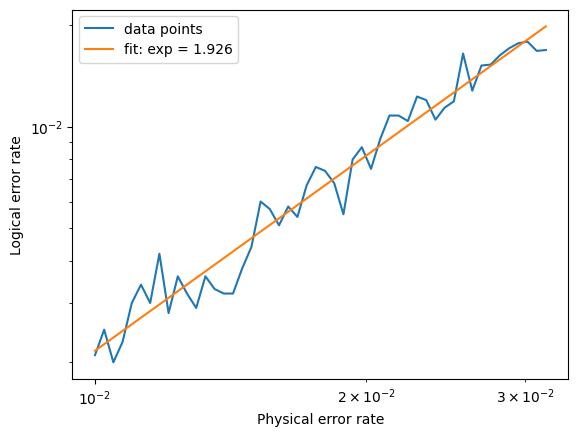

/home/leo/Documents/MasterArbeit/code/steane_type/support_functions.py:86: RuntimeWarning: divide by zero encountered in log
  popt, pcov = curve_fit(linear,np.log(noise),np.log(log_prob))


ValueError: array must not contain infs or NaNs

<Figure size 640x480 with 0 Axes>

In [ ]:
factory_set = [
    rec_factory(x) for x in [3,7,9,]
]
factory_set_2 = [
    rec_factory(
        5,
        basic_errors=False,
        fix_X_errors=True,
        fix_Z_errors=True,
        name_str="both",
    ),
    # rec_factory(
    #     3,
    #     basic_errors=True,
    #     fix_X_errors=False,
    #     fix_Z_errors=True,
    #     name_str="fix_Z_error",
    # ),
    rec_factory(
        3,
        basic_errors=True,
        fix_X_errors=True,
        fix_Z_errors=False,
        name_str="fix_X_error",
    ),
]

noise_set, log_error_data, y_errs = plot_factory_set(
    factory_set,
    num_shots=100_000,
    noise_set=np.logspace(-2,-1.5),
    filename="multiple_distances",
    reference_lines=True,
)

for i,log_e_rate  in enumerate(log_error_data):
    determine_slope(
        noise_set,
        log_prob=log_e_rate,
        plot=True,
        plotpath=plot_path+f"slope_{i}.pdf"
        )